In [47]:
import numpy as np
import pandas as pd

import tensorflow as tf

from keras.layers import Input, Embedding, LSTM, Dense, merge
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

import matplotlib.pyplot as plt

from keras.datasets import mnist

In [48]:
def plotImage(sample):
    plt.figure(figsize=(8,8))
    plt.imshow(sample)
    plt.show()

In [49]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [51]:
y_train_onehot = np.zeros((len(y_train), 10))

y_train_onehot[np.arange(len(y_train)), list(y_train)] = 1


In [52]:
y_train_onehot

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

# Auxillary input

In [67]:
aux_train = y_train + np.random.uniform(high=2,low=-2,size=len(y_train))

In [68]:
aux_train

array([ 5.22024508, -1.36219298,  5.26380582, ...,  3.41681325,
        7.38364598,  7.5213656 ])

In [77]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

main_input = Input(shape=(28,28,1), name='main_input')

#x = Convolution2D(32, 1, 1, border_mode='same', input_shape=[28, 28, 1], activation='relu')(inputs)
x = Convolution2D(32, 1, 1, border_mode='same', activation='relu')(main_input)
x = MaxPooling2D(pool_size=(2, 2))(x)

x_out = Flatten()(x)

# adding in auxillary input
aux_input = Input(shape=(1,), name='aux_input')

x = merge([x_out, aux_input], mode='concat')

x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(10)(x)
predictions = Activation('softmax')(predictions)

model = Model(input = [main_input, aux_input], output = predictions)

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

In [78]:
nb_epoch = 15
batch_size = 32

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')     

In [79]:
history = LossHistory()

training_x = np.array(X_train).astype(float)
training_y = np.array(y_train_onehot).astype(float)

In [80]:
np.shape(training_x)

(60000, 28, 28)

In [81]:
training_x = np.reshape(training_x, newshape=(60000, 28, 28, 1))

In [82]:
model.fit([training_x,aux_train], training_y, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.20, verbose=0, shuffle=True, callbacks=[history, early_stopping])

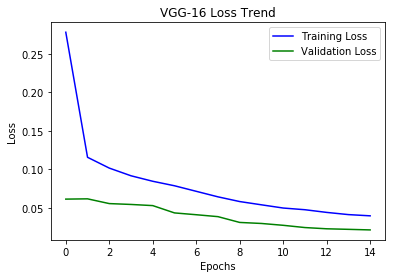

In [83]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [84]:
predictions = model.predict([training_x,aux_train], verbose=0)

In [85]:
predictions[3]

array([  4.41863136e-07,   9.99806821e-01,   9.23464468e-05,
         3.66660315e-05,   8.14251780e-06,   6.18085232e-06,
         1.18544529e-06,   2.96252274e-05,   1.82955773e-05,
         1.11052969e-07], dtype=float32)

In [86]:
training_y[3]

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])